# Classification using Dictionary Learning 

We use Sparse Coding/ Dictionary Learning to create feature vectors and classify videos from flat and ridged surface (without electric field) using SVM

In [4]:
import numpy as np

## File Upload

We read the tiff image files from the corresponding folders for videos from flat and ridged surface without any eleectric field


In [5]:
from skimage import io
import os
import glob
img_dir = "flat cell videos/nofield"  
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_nofield.append(img)
    
    
img_dir = "ridged cell videos/nofield" 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_nofield.append(img)


## Displaying images

Here we display an image frame from a video of cell motion on flat surface

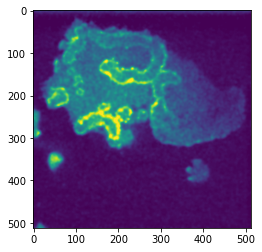

In [7]:
import matplotlib.pyplot as plt
im2 = flat_nofield[2] / 255.
im2 = np.moveaxis(im2,(0,1,2),(1,2,0))
plt.imshow(im2[21])

## Dictionary Learning

Here we use scikit-learn's MiniBatchDictionaryLearning to learn a set of dictionary atoms which gives a good representation of the image frames in our videos. First we learn a set of 100 atoms and display the visual feature represented by each atom.

done in 99.18s.


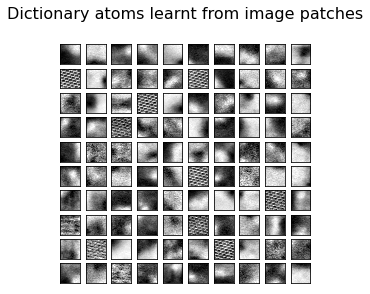

In [11]:
from time import time
import scipy as sp

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

import PIL
from PIL import Image

X_flattrain = np.concatenate(flat_nofield, axis=2)
X_ridgetrain = np.concatenate(ridged_nofield, axis=2)
im1 = np.concatenate((X_flattrain,X_ridgetrain), axis=2)
im1 = np.moveaxis(im1,(0,1,2),(1,2,0))

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
im1 = im1 / 255.

rng = np.random.RandomState(0)
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1.0, n_iter=1500, batch_size=15)


buffer = []
t0 = time()
patch_size = (20,20)


for image in im1:
    data = extract_patches_2d(image, patch_size, max_patches=300,
                                  random_state=rng)
    data = np.reshape(data, (len(data), -1))
    buffer.append(data)
        
data = np.concatenate(buffer, axis=0)
            
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)


plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary atoms learnt from image patches\n',
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)


plt.show()

## Truncating the number of atoms

In order to truncate the number of atoms, we check how reconstruction of the image frames is affected by removing one of the atoms and rank the atoms by giving more importance to the atom, the removal of which leads to larger reconstruction error. We plot the reconstruction error versus the atom index and then choose the top 30 atoms and display them.

In [14]:
im2 = []
for i in range(len(flat_nofield)):
    j = 0
    while j < flat_nofield[i].shape[2]:
        im2.append(flat_nofield[i][:,:,j])
        j = j + 5
for i in range(len(ridged_nofield)):
    j = 0
    while j < ridged_nofield[i].shape[2]:
        im2.append(ridged_nofield[i][:,:,j])
        j = j + 5
im2 = np.asarray(im2)
im2 = im2 / 255.

In [ ]:
from sklearn.feature_extraction.image import PatchExtractor
pe = PatchExtractor(patch_size=(20, 20), max_patches=100, random_state=rng)
pe_trans = pe.transform(im2)

data = pe_trans.reshape(pe_trans.shape[0], -1)

from sklearn.decomposition import sparse_encode

code = sparse_encode(data, V, algorithm='lasso_lars', alpha=1.0, max_iter=100000)
data_rec = np.dot(code, V)

rec_error = (np.linalg.norm(data - data_rec))**2
print(rec_error)

F = np.zeros(V.shape[0])
for i in range(V.shape[0]):
    arr = np.delete(V, (i), axis=0)
    sparse2 = sparse_encode(data, arr, algorithm='lasso_cd', alpha=1.0, max_iter=100000)
    data_rec2 = np.dot(sparse2, arr)
    rec_error2 = (np.linalg.norm(data - data_rec2))**2
    F[i] = (rec_error2 - rec_error) / (rec_error)
    print('done for %i th atom' % i)

[6.09791063e-04 2.06319503e-04 7.57157151e-04 1.73258010e-04
 3.81488390e-04 4.44195214e-05 2.59643615e-03 2.74252127e-04
 1.52853796e-05 8.86322101e-05 6.27798736e-05 3.44436728e-05
 1.37990978e-05 4.93492643e-05 4.52464074e-04 1.57179301e-04
 1.66486423e-03 1.91577464e-04 1.82109120e-04 4.10731937e-03
 4.09027868e-04 1.77962775e-04 6.06935471e-04 5.93072130e-05
 3.54010712e-04 3.87386458e-06 2.54383750e-05 7.60578965e-05
 1.27028442e-04 3.21710255e-03 2.43081733e-04 2.01321076e-05
 1.13006579e-04 7.39261087e-04 9.62803373e-04 2.39824786e-04
 1.15374786e-04 5.98960606e-04 5.69837516e-04 1.25287308e-03
 8.67922904e-04 4.32307785e-04 2.25610694e-05 4.33671541e-05
 3.17708640e-04 2.34601017e-06 7.36776280e-04 1.28229003e-04
 1.83137938e-04 2.08210995e-05 4.61710522e-03 3.33909422e-04
 2.03908056e-05 2.87309080e-04 1.29710348e-04 3.81820386e-03
 6.49230038e-04 7.42892631e-05 5.00809760e-03 1.80516104e-03
 4.23415885e-06 2.44809812e-03 1.00415281e-04 1.49826492e-03
 3.84575279e-04 6.184364

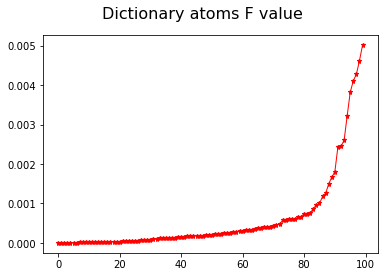

In [40]:
print(F)
plt.plot(np.sort(F),'r*-', linewidth=1, markersize=5)
plt.suptitle('Dictionary atoms F value ',
             fontsize=16)
plt.show()

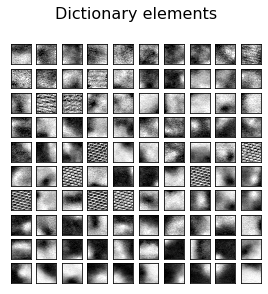

In [41]:
a = np.argsort(F)

V_sorted = np.zeros_like(V)

for i in range(V_sorted.shape[0]):
    V_sorted[i,:] = V[a[i],:]

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V_sorted):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary elements',
             fontsize=16)    
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

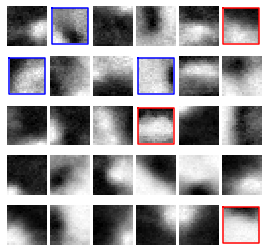

In [193]:
patch_size = (20,20)
xs = [-1,20,20,-1,-1]
ys = [-1,-1,20,20,-1]
V1 = np.load('dictionary_new.npy')
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V1):
    plt.subplot(5, 6, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    if i in [5,15,29]:
        plt.plot(xs, ys, color="red")
    elif i in [1,6,9]:
        plt.plot(xs, ys, color="blue")
    plt.xticks(())
    plt.yticks(())
    plt.axis('off')
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.savefig("dictionary_atoms.png")
plt.show()

## Creating the feature vectors

After we sparse encode the image frames using the learnt dictionary atoms, we produce the feature vectors here which we use as an input to our classifier

In [206]:
from sklearn.decomposition import sparse_encode
from sklearn.feature_extraction.image import extract_patches_2d

def coding(input_list):
    X = []
    for i in range(len(input_list)):
        Y = []
        input = input_list[i] / 255.
        for j in range(input.shape[2]):
            data1 = extract_patches_2d(input[:,:,j], (20,20))
            data1 = np.reshape(data1, (len(data1), -1))
            code = sparse_encode(data1, V1, algorithm='lasso_cd', alpha=1.5, max_iter=5000)
            code_dict = np.linalg.norm(code, ord=1, axis=0)
            Y.append(code_dict)
        Y = np.asarray(Y)
        X.append(Y)
        print('done for %i th sample' % i)
    return(X)

In [ ]:
flat = coding(flat_nofield)
ridged = coding(ridged_nofield)

In [8]:
flat = np.load('flat_sparsecode_new.npy', allow_pickle=True)
ridged = np.load('ridged_sparsecode_new.npy', allow_pickle=True)

## Data splits and classification using SVM

We create 3 different splits of the dataset. Then use two of the splits as our training data and the remaining split as the test data. We fit a SVM classifer to the trainind data, then predict on the test data and display the classification results using a confusion matrix.

In [9]:
flat_set1 = np.concatenate((flat[0],flat[1],flat[2],flat[3]),axis=0)
flat_set2 = np.concatenate((flat[4],flat[5],flat[6],flat[7]),axis=0)
flat_set3 = np.concatenate((flat[8],flat[9],flat[10],flat[11]),axis=0)
#ridged_set1 = np.concatenate((ridged[0],ridged[1]),axis=0)
ridged_set1 = ridged[0]
ridged_set2 = np.concatenate((ridged[2],ridged[3]),axis=0)
ridged_set3 = np.concatenate((ridged[4],ridged[5]),axis=0)

In [11]:
flat_set1_labels = np.zeros((flat_set1.shape[0],))
flat_set2_labels = np.zeros((flat_set2.shape[0],))
flat_set3_labels = np.zeros((flat_set3.shape[0],))
ridged_set1_labels = np.ones((ridged_set1.shape[0],))
ridged_set2_labels = np.ones((ridged_set2.shape[0],))
ridged_set3_labels = np.ones((ridged_set3.shape[0],))

In [12]:
X_test = np.concatenate((flat_set2,ridged_set2),axis=0)/243049
y_test = np.concatenate((flat_set2_labels,ridged_set2_labels),axis=0)
X_train = np.concatenate((flat_set1,flat_set3,ridged_set1,ridged_set3),axis=0)/243049
y_train = np.concatenate((flat_set1_labels,flat_set3_labels,ridged_set1_labels,ridged_set3_labels),axis=0)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from time import time

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5]}               
clf = GridSearchCV(
    LinearSVC(class_weight=None, dual=False, max_iter=1000000000, penalty='l1'), param_grid
)
clf = clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 0.680s
Best estimator found by grid search:
LinearSVC(C=100.0, dual=False, max_iter=1000000000, penalty='l1')


In [28]:
from sklearn import svm, metrics

#classifier = LinearSVC(penalty='l1', dual=False, C=1.0, max_iter=10000)
classifier = LinearSVC(C=1000, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000000000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

classifier.score(X_test,y_test)

Classification report for classifier LinearSVC(C=1000, dual=False, max_iter=1000000000, penalty='l1'):
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       284
         1.0       1.00      0.90      0.94       153

    accuracy                           0.96       437
   macro avg       0.97      0.95      0.96       437
weighted avg       0.97      0.96      0.96       437




0.9633867276887872

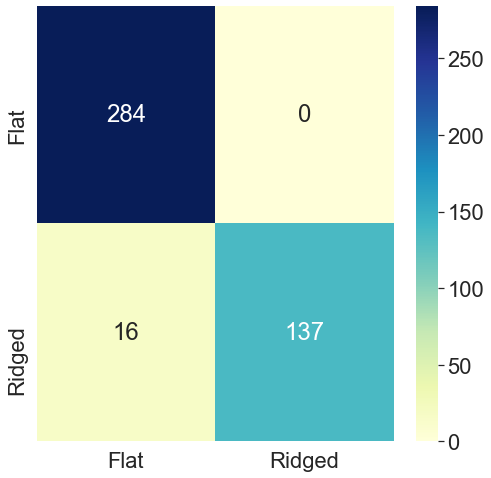

In [29]:
import seaborn as sn
import pandas as pd


a = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
df_cm = pd.DataFrame(a, range(2), range(2))
plt.figure(figsize=(8,8))
df_cm = df_cm.rename(index={0: "Flat", 1: "Ridged"}, columns={0: "Flat", 1: "Ridged"})
sn.set(font_scale=2.0) # for label size
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt='.0f') # font size

plt.show()